# Aprendizaje Profundo

Franco Cerino

#Práctico 1
En este práctico trabajaremos con el conjuto de datos de petfinder que utilizaron en la materia Aprendizaje Supervisado. La tarea es predecir la velocidad de adopción de un conjunto de mascotas. Para ello, también utilizaremos esta competencia de Kaggle.

Durante esta etapa implementaremos modelos MLP básicos y no tan básicos, y veremos los diferentes hiperparámetros y arquitecturas que podemos elegir. Compararemos además dos tipos de representaciones comunes para datos categóricos: one-hot-encodings y embeddings. El primer ejercicio consiste en implementar y entrenar un modelo básico, y el segundo consiste en explorar las distintas combinaciones de características e hiperparámetros.

Para resolver los ejercicios, les proveemos un esqueleto que pueden completar en el archivo practico_1_train_petfinder.py. Este esqueleto ya contiene muchas de las funciones para combinar las representaciones de las distintas columnas que vimos en la notebook 2, aunque pueden agregar más columnas y las columnas con valores numéricos.

#Ejercicio 1
Construir un pipeline de clasificación con un modelo Keras MLP. Pueden comenzar con una versión simplicada que sólo tenga una capa de Input donde pasen los valores de las columnas de one-hot-encodings.

Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de dev y test.

#Ejercicio 2
Utilizar el mismo modelo anterior y explorar cómo cambian los resultados a medida que agregamos o quitamos columnas.

Volver a ejecutar una exploración de hyperparámetros teniendo en cuenta la información que agregan las nuevas columnas.

Subir los resultados a la competencia de Kaggle.

Finalmente, tienen que reportar los hyperparámetros y resultados de todos los modelos entrenados. Para esto, pueden utilizar los resultados que recolectan con mlflow y procesarlos con una notebook. Tiene que presentar esa notebook o un archivo (pdf|md) con las conclusiones que puedan sacar. Dentro de este reporte tiene que describir:

Hyperparámetros con los que procesaron cada columna del dataset. ¿Cuáles son las columnas que más afectan al desempeño? ¿Por qué?
Las decisiones tomadas al construir cada modelo: regularización, batch normalization, dropout, número y tamaño de las capas, optimizador.
Proceso de entrenamiento: división del train/dev, tamaño del batch, número de épocas, métricas de evaluación. Seleccione los mejores hiperparámetros en función de su rendimiento. El proceso de entrenamiento debería ser el mismo para todos los modelos.
Analizar si el clasificador está haciendo overfitting. Esto se puede determinar a partir del resultado del método fit.

In [1]:
%%bash
pip install --upgrade pip
pip install --upgrade tensorflow-gpu==2.0.0
pip install --upgrade mlflow graphviz pydot

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
Requirement already up-to-date: tensorflow-gpu==2.0.0 in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: mlflow in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: graphviz in /usr/local/lib/python3.6/dist-packages (0.13.2)
Requirement already up-to-date: pydot in /usr/local/lib/python3.6/dist-packages (1.4.1)


Importamos las librerias a utilizar, incluyendo Tensorflow 2.0.0

In [2]:
import tensorflow as tf
print("TensorFlow Version: {} - Is GPU available: {}".format(tf.__version__, tf.test.is_gpu_available()))

TensorFlow Version: 2.0.0 - Is GPU available: False


In [3]:
import argparse

import os
import mlflow
import numpy
import pandas

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [0]:
import sklearn
from sklearn import preprocessing

In [0]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):#test=False->valor default para test si no esta definido
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}#"num_columns":num_columns}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets

Cargamos librerias y dataset a utilizar.

In [0]:
import numpy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
import pandas as pd
import seaborn

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos y visualizamos el dataset.

In [10]:
dataset=pd.read_csv("/content/drive/My Drive/train.csv")
dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


In [11]:
dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


In [12]:
dataset.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000
mean,1.454734,10.520412,265.469854,74.388868,1.779059,2.230675,3.236912,1.856738,1.860518,1.460971,1.729730,1.566528,1.912115,1.036666,1.584011,20.809960,41345.994613,2.518900,7477.025799
std,0.497970,18.374027,60.121490,123.434010,0.684763,1.743985,2.748595,2.974465,0.547535,0.593843,0.670791,0.701482,0.564041,0.198228,1.488348,78.397243,32.409109,1.176018,4310.921553
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3768.250000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7473.500000
75%,2.000000,12.000000,307.000000,188.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11200.750000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,4.000000,14992.000000


In [13]:
test_dataset=pd.read_csv("/content/drive/My Drive/test.csv")
test_dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7
3,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,"Very manja and gentle stray cat found, we woul...",9
4,2,3,264,0,2,1,2,5,3,3,1,1,2,1,1,50,41326,Kali is a super playful kitten who is on the g...,11


In [14]:
dataset.dtypes

Type              int64
Age               int64
Breed1            int64
Breed2            int64
Gender            int64
Color1            int64
Color2            int64
Color3            int64
MaturitySize      int64
FurLength         int64
Vaccinated        int64
Dewormed          int64
Sterilized        int64
Health            int64
Quantity          int64
Fee               int64
State             int64
Description      object
AdoptionSpeed     int64
PID               int64
dtype: object

Comenzamos con un modelo que utilice algunas columnas.

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age', 'Fee']

Visualizamos las diferentes velocidades de adopción en un histograma:

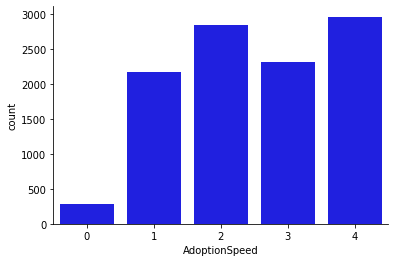

In [16]:
seaborn.countplot(dataset.AdoptionSpeed, color='blue')
seaborn.despine()

---------------------------


In [17]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

TensorFlow is already loaded. Please restart the runtime to change versions.


In [18]:
tf.__version__

'2.0.0'

In [0]:
import mlflow

In [0]:
#mlflow ui -p PORT

In [0]:
#perceptron multicapa

#definimos el modelo de la red neuronal
#model = Sequential([
#    Dense(64, input_shape=(784,), activation='relu'),
#    BatchNormalization(momentum=0),
#    Dropout(0.5),
#    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
#    Dense(10, activation='softmax')
#])

In [22]:
print (dataset["Gender"],"\n")

print(dataset["Gender"].max())

0        1
1        2
2        1
3        2
4        1
        ..
10577    1
10578    1
10579    3
10580    2
10581    1
Name: Gender, Length: 10582, dtype: int64 

3


In [23]:
print (one_hot_columns)
print (embedded_columns)

{'Gender': 3, 'Color1': 7}
{'Breed1': 308}


In [24]:
one_hot_columns.items()

dict_items([('Gender', 3), ('Color1', 7)])

In [25]:
# Create one hot encodings
direct_features = []
for one_hot_col, max_value in one_hot_columns.items():
      direct_features.append(tf.keras.utils.to_categorical(dataset[one_hot_col] - 1, max_value))

direct_features      

[array([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32), array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)]

In [26]:
print (dataset["Gender"],"\n")
print( dataset["Color1"])

0        1
1        2
2        1
3        2
4        1
        ..
10577    1
10578    1
10579    3
10580    2
10581    1
Name: Gender, Length: 10582, dtype: int64 

0        1
1        1
2        1
3        5
4        1
        ..
10577    1
10578    2
10579    1
10580    4
10581    2
Name: Color1, Length: 10582, dtype: int64


In [0]:
import numpy as np

In [0]:
TARGET_COL="AdoptionSpeed"
target_col="AdoptionSpeed"

In [0]:
X_train, y_train=process_features(dataset, one_hot_columns, numeric_columns, embedded_columns, test=False) #X_train, y_train=features,targets

In [30]:
X_train

{'Breed1': array([299, 307, 307, ..., 266, 266, 307]),
 'direct_features': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

In [0]:
test_dataset=process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)

#test_dataset = tf.data.Dataset.from_tensor_slices(
#    process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)).batch(batch_size)

In [32]:
type(test_dataset)

tuple

In [33]:
test_dataset

({'Breed1': array([265, 307, 307, ..., 195, 265, 265]),
  'direct_features': array([[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 1., ..., 1., 0., 0.]], dtype=float32)},
 None)

In [36]:
X_train['direct_features'].shape

(10582, 10)

In [37]:
direct_features_input_shape = (X_train['direct_features'].shape[1],)
direct_features_input_shape

(10,)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Take a sample of data
dataset, dev_dataset = train_test_split(dataset, test_size=0.2)

In [40]:
dataset.shape

(8465, 20)

In [41]:
dev_dataset.shape

(2117, 20)

In [43]:
X_train

{'Breed1': array([299, 307, 307, ..., 266, 266, 307]),
 'direct_features': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

In [0]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)).batch(batch_size)

In [45]:
x_batch, y_batch = next(iter(train_ds))
x_batch, y_batch

({'Breed1': <tf.Tensor: id=20, shape=(32,), dtype=int64, numpy=
  array([299, 307, 307, 266, 264, 265, 307, 265, 307, 218, 266, 307, 307,
         266, 307, 307, 114, 307, 266, 285, 266, 189, 266, 205, 266, 307,
         265, 265, 307, 307, 265, 266])>,
  'direct_features': <tf.Tensor: id=21, shape=(32, 10), dtype=float32, numpy=
  array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
     

In [46]:
nlabels = dataset[target_col].unique().shape[0]
nlabels

5

Probamos con hidden_layer_size = 64 y agregamos layers para ver que tan bien aprende la red neuronal.

In [47]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)

#dense1 = Dropout(0.2)(dense1)

dense2 = layers.Dense(hidden_layer_size, activation='relu')(dense1)

############
#si queremos agregar varias capas:
#capas=4
#for a in range(capas):
#  dense3=layers.Dense(hidden_layer_size, activation='relu')(dense2)
#  dense2=dense3
############

output_layer = layers.Dense(nlabels, activation='relu')(dense2)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),#versi esta bien este adam
                  # También podría ser el string "Adagrad" con los parámetros por defecto
              metrics=['accuracy'])

In [49]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', 64)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 100 #500
    historya = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
331/331 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.0275 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 4/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.0269 - val_loss: nan - val_accuracy: 0.0222
Epoch 8/100
331/331 [================

Visualizamos el modelo utilizado:

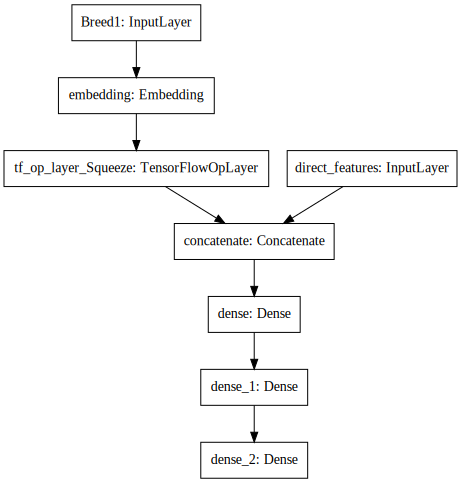

In [50]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

Veamos los resultados obtenidos:

In [52]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [53]:
type(test_dataset)

tuple

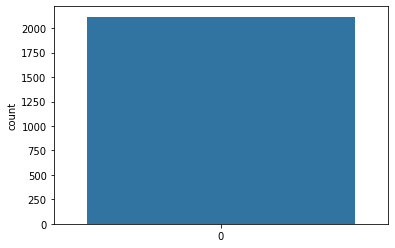

In [54]:
predictions = numpy.argmax(model.predict(test_ds), axis=1)
seaborn.countplot(predictions);

In [55]:
# list all data in history
print(historya.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [56]:
#history.history
np.shape(list(historya.history.values())[1])

(100,)

Comparamos las accuracy de conjunto de entrenamiento y de test, si difieren  entre si  de forma notable, se tiene un indicio de overfitting. 

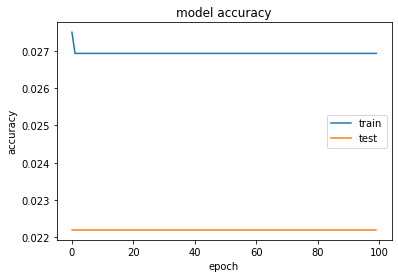

In [57]:
# summarize history for accuracy
plt.plot(historya.history['accuracy'])
plt.plot(historya.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test']);


Pareciera no haber overfitting, ya que los accuracy son similares. Para el modelo utilizado no obtuvimos gran efectividad en las predicciones.

-----------------------------------------------



Probamos con otro modelo, con diferentes layers. Entre ellos, utilizamos un dropout. Queremos ver como afecta la arquitectura de la red en el resultado.

In [60]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

# Concatenate everything together
# es lo que va a ir a la primer capa Dense
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)

#agregamos un dropout
dense1 = Dropout(0.2)(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

Vemos gráficamente como quedó el modelo

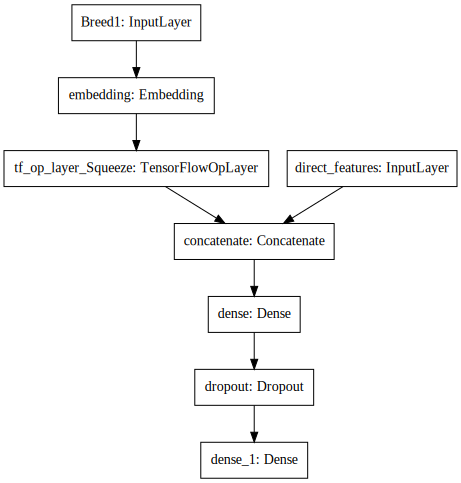

In [61]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))


In [63]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    #mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
331/331 [==============================] - 3s 8ms/step - loss: 1.4724 - accuracy: 0.2960 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
331/331 [==============================] - 1s 3ms/step - loss: 1.4417 - accuracy: 0.3236 - val_loss: 1.4208 - val_accuracy: 0.3429
Epoch 3/100
331/331 [==============================] - 1s 3ms/step - loss: 1.4350 - accuracy: 0.3285 - val_loss: 1.4127 - val_accuracy: 0.3382
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 1.4286 - accuracy: 0.3333 - val_loss: 1.4057 - val_accuracy: 0.3524
Epoch 5/100
331/331 [==============================] - 1s 3ms/step - loss: 1.4218 - accuracy: 0.3371 - val_loss: 1.3996 - val_accuracy: 0.3481
Epoch 6/100
331/331 [==============================] - 1s 3ms/step - loss: 1.4177 - accuracy: 0.3388 - val_loss: 1.3946 - val_accuracy: 0.3500
Epoch 7/100
331/331 [==============================] - 1s 3ms/step - loss: 1.4164 - accuracy: 0.3390 - val_loss: 1.3901 - val_accuracy

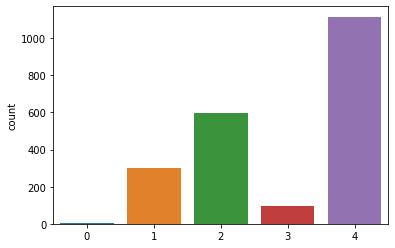

In [64]:
predictions = numpy.argmax(model.predict(test_ds), axis=1)
seaborn.countplot(predictions);

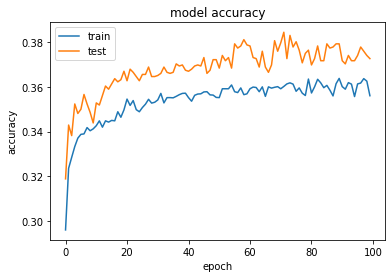

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

Al menos hasta el epoch 100, no se ve que se produzca overfitting a epochs grandes. En caso de producirse, se tendria que entrenar la red con menos epochs.

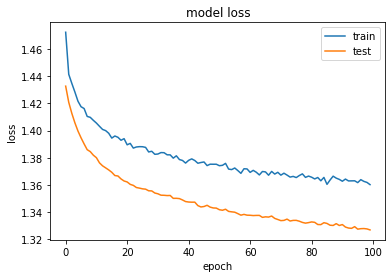

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

El cambio de red produjo mejores resultados, esto se puede visualizar en valores mayores de accuracy.

En cuanto al parámetro loss, este último modelo también funcionó mejor.

---------------

Vemos que resultados obtenemos con otro modelo. Utilizamos varios layers con softmax como funcion de activacion.

In [67]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='softmax')(features)

dense2 = layers.Dense(hidden_layer_size, activation='softmax')(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense2)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [68]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

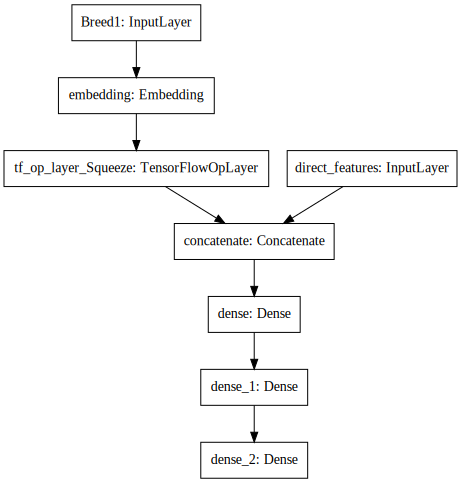

In [69]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [70]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
331/331 [==============================] - 2s 7ms/step - loss: 0.1600 - accuracy: 0.2035 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1592 - accuracy: 0.2801 - val_loss: 0.1589 - val_accuracy: 0.2631
Epoch 3/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1585 - accuracy: 0.2801 - val_loss: 0.1582 - val_accuracy: 0.2631
Epoch 4/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1579 - accuracy: 0.2801 - val_loss: 0.1576 - val_accuracy: 0.2631
Epoch 5/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1573 - accuracy: 0.2801 - val_loss: 0.1571 - val_accuracy: 0.2631
Epoch 6/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.2801 - val_loss: 0.1567 - val_accuracy: 0.2631
Epoch 7/100
331/331 [==============================] - 1s 2ms/step - loss: 0.1564 - accuracy: 0.2801 - val_loss: 0.1563 - val_accuracy

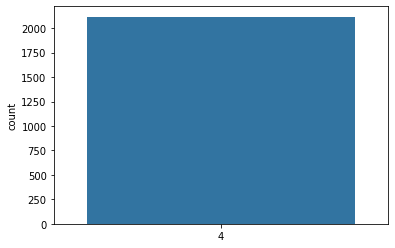

In [71]:
predictions = numpy.argmax(model.predict(test_ds), axis=1)
seaborn.countplot(predictions);

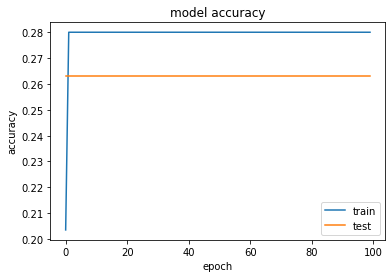

In [72]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test']);


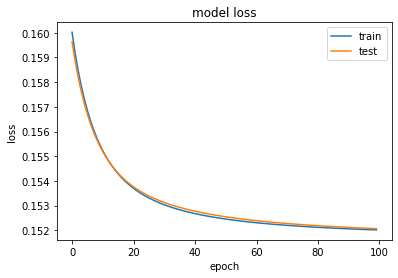

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

Loss decrece a mayor epoch.

La arquitectura de este modelo genera resultados menos convincentes que el anterior.

En los modelos utilizados no parece gererar problemas utilizar un numero de epoch grande, no genera una tendencia a tener overfitting.

---------------------------

About batch size:

From Nitish Shirish Keskar, Dheevatsa Mudigere, Jorge Nocedal, Mikhail Smelyanskiy, Ping Tak Peter Tang. On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima. https://arxiv.org/abs/1609.04836 :

The stochastic gradient descent method and its variants are algorithms of choice for many Deep Learning tasks. These methods operate in a small-batch regime wherein a fraction of the training data, usually 32--512 data points, is sampled to compute an approximation to the gradient. It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize. 

Vamos a probar el modelo anterior con batch sizes diferentes (solo cambiamos este parámetro) y compararemos los resultados.

In [0]:
batch_size = 32*2
# TODO shuffle the train dataset!
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)).batch(batch_size)

In [0]:
x_batch, y_batch = next(iter(train_ds))
#x_batch, y_batch

In [76]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='softmax')(features)

#dense1 = Dropout(0.2)(dense1)

dense2 = layers.Dense(hidden_layer_size, activation='softmax')(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense2)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [77]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [78]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history64 = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
166/166 [==============================] - 2s 10ms/step - loss: 0.1597 - accuracy: 0.2183 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.2436 - val_loss: 0.1591 - val_accuracy: 0.2825
Epoch 3/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1589 - accuracy: 0.2689 - val_loss: 0.1587 - val_accuracy: 0.2825
Epoch 4/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1586 - accuracy: 0.2689 - val_loss: 0.1584 - val_accuracy: 0.2825
Epoch 5/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.2689 - val_loss: 0.1581 - val_accuracy: 0.2825
Epoch 6/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.2689 - val_loss: 0.1578 - val_accuracy: 0.2825
Epoch 7/100
166/166 [==============================] - 0s 3ms/step - loss: 0.1577 - accuracy: 0.2689 - val_loss: 0.1575 - val_accurac

In [0]:
batch_size = 32*3

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)).batch(batch_size)

In [80]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='softmax')(features)

#dense1 = Dropout(0.2)(dense1)

dense2 = layers.Dense(hidden_layer_size, activation='softmax')(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense2)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [0]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])

In [82]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history128 = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
111/111 [==============================] - 1s 11ms/step - loss: 0.1608 - accuracy: 0.0269 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1605 - accuracy: 0.0269 - val_loss: 0.1603 - val_accuracy: 0.0222
Epoch 3/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.1906 - val_loss: 0.1600 - val_accuracy: 0.2631
Epoch 4/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.2801 - val_loss: 0.1598 - val_accuracy: 0.2631
Epoch 5/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1596 - accuracy: 0.2801 - val_loss: 0.1595 - val_accuracy: 0.2631
Epoch 6/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.2801 - val_loss: 0.1592 - val_accuracy: 0.2631
Epoch 7/100
111/111 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.2801 - val_loss: 0.1590 - val_accurac

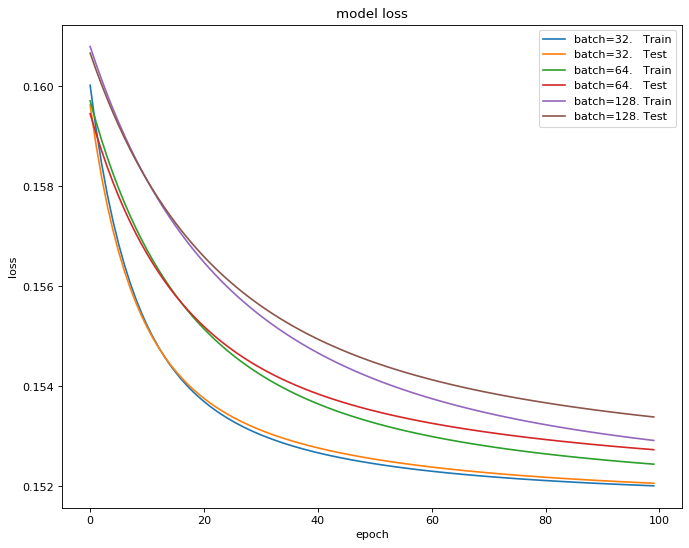

In [83]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history.history['loss'],label="batch=32.   Train")
plt.plot(history.history['val_loss'],label="batch=32.   Test")

plt.plot(history64.history['loss'],label="batch=64.   Train")
plt.plot(history64.history['val_loss'],label="batch=64.   Test")

plt.plot(history128.history['loss'],label="batch=128. Train")
plt.plot(history128.history['val_loss'],label="batch=128. Test")


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

Podemos ver que los resultados obtenidos muestran mejores resultados a menor batch size, de acuerdo con lo observado en el paper mencionado.

Podriamos utilizar mas epochs para mejorar la efectividad del modelo, debido a la tendencia que muestran las curvas.

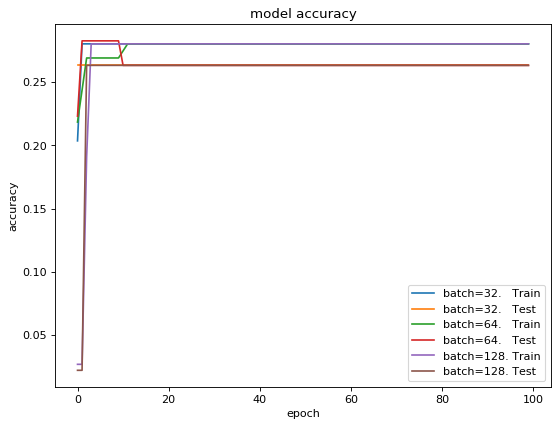

In [84]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history.history['accuracy'],label="batch=32.   Train")
plt.plot(history.history['val_accuracy'],label="batch=32.   Test")

plt.plot(history64.history['accuracy'],label="batch=64.   Train")
plt.plot(history64.history['val_accuracy'],label="batch=64.   Test")

plt.plot(history128.history['accuracy'],label="batch=128. Train")
plt.plot(history128.history['val_accuracy'],label="batch=128. Test")


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

Con ningun batch size logramos superar 0,30 de accuracy. Necesitamos encarar el problema por otro lado si queremos obtener una eficiencia significativamente mejor.

-------------------------------------------

Ahora agregamos columnas numéricas:

In [0]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):#test=False->valor default para test si no esta definido
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}#"num_columns":num_columns}

    for numeric_col in ['Age', 'Fee']:
      features[numeric_col] = numpy.hstack(tf.keras.utils.normalize(df[numeric_col].values)) 

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets

In [0]:
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)#test=False->valor default para test si no esta definido

In [91]:
direct_features_input_shape = (X_train['direct_features'].shape[1])
direct_features_input_shape

10

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)).batch(batch_size)

In [97]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

# Add the numeric features 
#numeric_columns = ['Age', 'Fee']

numeric_layers=[]
for elem in numeric_columns:
  input_layer = layers.Input(shape=(1,), name=elem)
  inputs.append(input_layer)
  
  numeric_layers.append(input_layer)

# Concatenate everything together
# es lo que va a ir a la primer capa Dense
features = layers.concatenate(embedding_layers + [direct_features_input]+numeric_layers)

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)

#agregamos un dropout
dense1 = Dropout(0.2)(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [0]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])

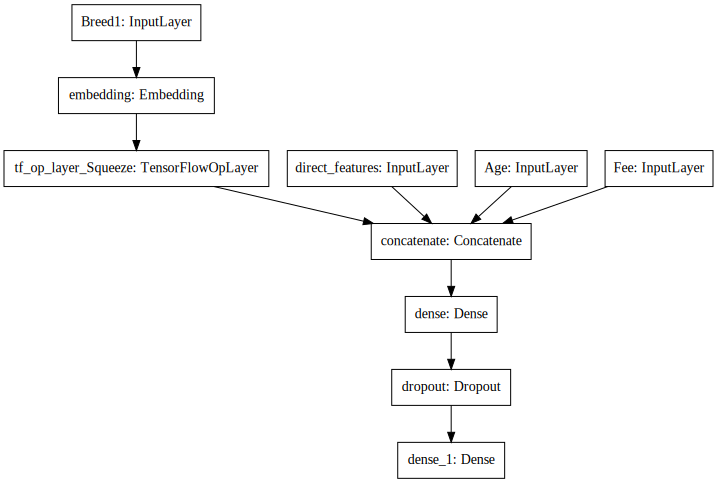

In [99]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [100]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
89/89 [==============================] - 1s 12ms/step - loss: 0.1584 - accuracy: 0.2450 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1582 - accuracy: 0.2451 - val_loss: 0.1579 - val_accuracy: 0.2489
Epoch 3/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.2494 - val_loss: 0.1576 - val_accuracy: 0.2475
Epoch 4/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.2575 - val_loss: 0.1573 - val_accuracy: 0.2470
Epoch 5/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.2533 - val_loss: 0.1571 - val_accuracy: 0.2537
Epoch 6/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.2620 - val_loss: 0.1568 - val_accuracy: 0.2617
Epoch 7/100
89/89 [==============================] - 0s 3ms/step - loss: 0.1567 - accuracy: 0.2699 - val_loss: 0.1566 - val_accuracy: 0.2674
Epoc

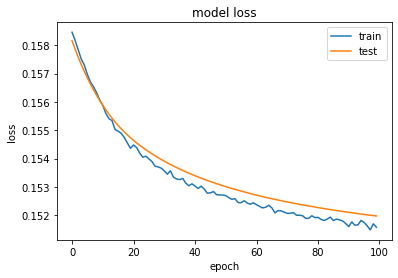

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

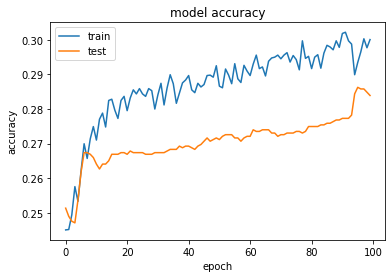

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

---------------------------------------------

Probamos con más columnas:

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2','Color3',"Type","Vaccinated","Dewormed",	"Sterilized"]
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age', 'Fee','Quantity',"MaturitySize","FurLength"]

In [0]:
def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):#test=False->valor default para test si no esta definido
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}#"num_columns":num_columns}

    for numeric_col in ['Age', 'Fee','Quantity',"MaturitySize","FurLength"]:
      features[numeric_col] = numpy.hstack(tf.keras.utils.normalize(df[numeric_col].values)) 

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets

In [0]:
dataset=pd.read_csv("/content/drive/My Drive/train.csv")

In [0]:
# Take a sample of data
dataset, dev_dataset = train_test_split(dataset, test_size=0.2)

In [0]:
nlabels = dataset[TARGET_COL].unique().shape[0]

In [0]:
X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)#test=False->valor default para test si no esta definido

In [109]:
direct_features_input_shape = (X_train['direct_features'].shape[1])
direct_features_input_shape

35

In [0]:
batch_size=32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns, test=False)).batch(batch_size)

In [112]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

# Add the numeric features 
#numeric_columns = ['Age', 'Fee']

numeric_layers=[]
for elem in numeric_columns:
  input_layer = layers.Input(shape=(1,), name=elem)
  inputs.append(input_layer)
  
  numeric_layers.append(input_layer)

#numeric_layers_input=layers.Input(shape=(1,),name="numeric_features")
#inputs.append(numeric_layers_input)

# Concatenate everything together
# es lo que va a ir a la primer capa Dense
features = layers.concatenate(embedding_layers + [direct_features_input]+numeric_layers)

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)

#agregamos un dropout
dense1 = Dropout(0.2)(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


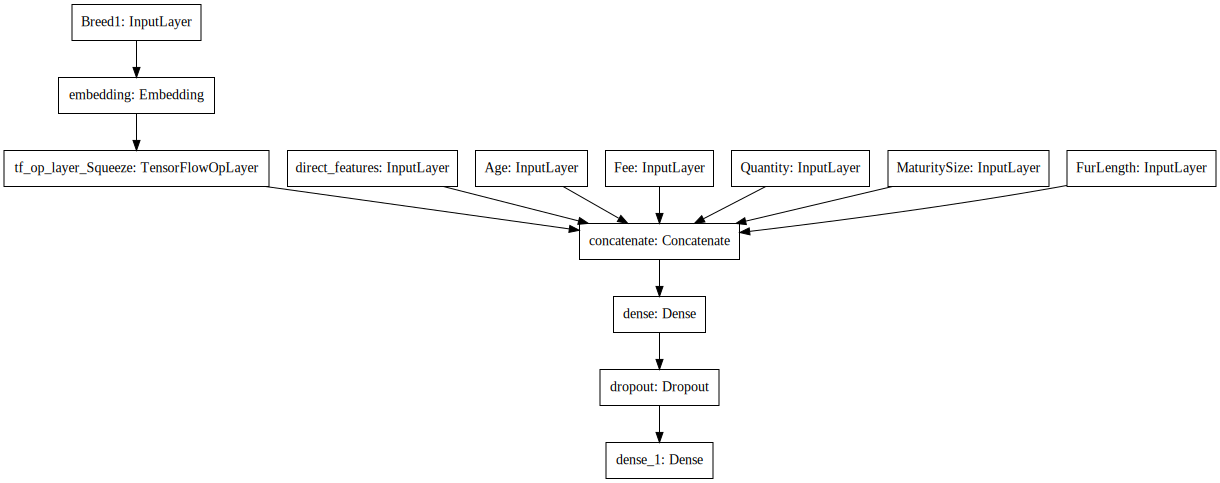

In [113]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [0]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])

In [115]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
265/265 [==============================] - 2s 8ms/step - loss: 0.1598 - accuracy: 0.2415 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1577 - accuracy: 0.2605 - val_loss: 0.1555 - val_accuracy: 0.2801
Epoch 3/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1562 - accuracy: 0.2637 - val_loss: 0.1545 - val_accuracy: 0.2976
Epoch 4/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1552 - accuracy: 0.2725 - val_loss: 0.1537 - val_accuracy: 0.3037
Epoch 5/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1546 - accuracy: 0.2763 - val_loss: 0.1531 - val_accuracy: 0.3099
Epoch 6/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1540 - accuracy: 0.2806 - val_loss: 0.1526 - val_accuracy: 0.3075
Epoch 7/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1535 - accuracy: 0.2849 - val_loss: 0.1522 - val_accuracy

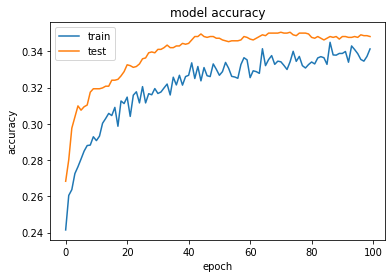

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

Al agregar más columnas el modelo ha mostrado una accuracy mayor. Ha podido entrenarse de mejor forma con más datos.

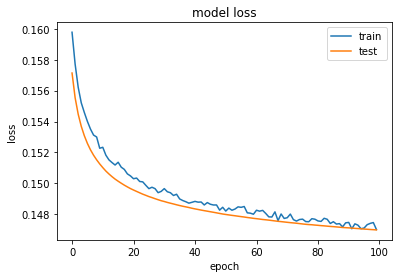

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

-------------------------------

Veamos como va si al parámetro de dropout le asignamos un valor alto. Apagaremos gran parte de las neuronas.

In [118]:
tf.keras.backend.clear_session()

hidden_layer_size = 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)


numeric_layers=[]
for elem in numeric_columns:
  input_layer = layers.Input(shape=(1,), name=elem)
  inputs.append(input_layer)
  
  numeric_layers.append(input_layer)


# Concatenate everything together
# es lo que va a ir a la primer capa Dense
features = layers.concatenate(embedding_layers + [direct_features_input]+numeric_layers)

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)

#agregamos un dropout
dense1 = Dropout(0.9)(dense1)

output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


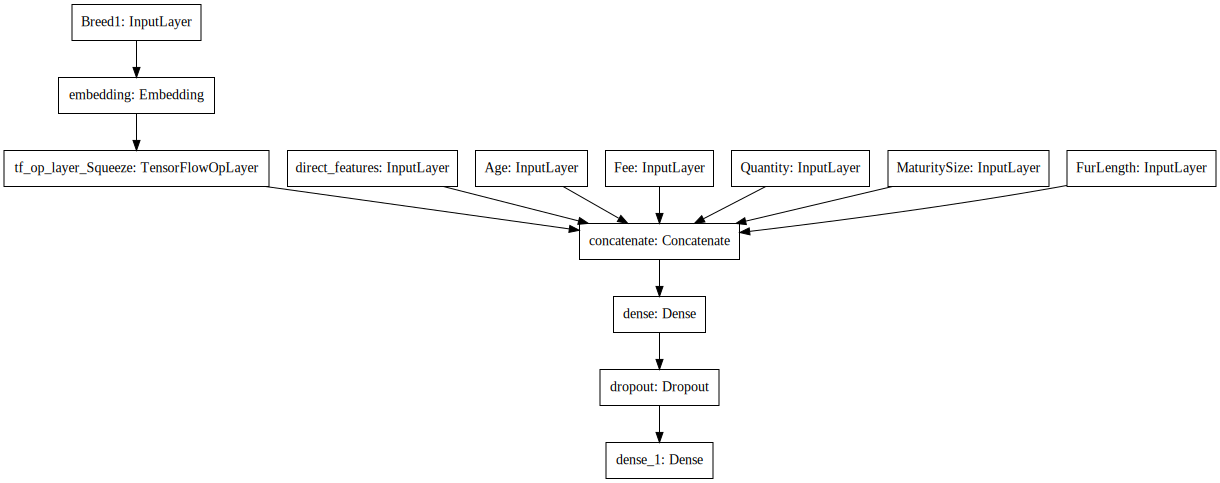

In [119]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

In [0]:
model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=['accuracy'])

In [121]:
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
    
    # Train
    epochs = 100
    history09 = model.fit(train_ds, epochs=epochs,validation_data=test_ds)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/100
265/265 [==============================] - 2s 8ms/step - loss: 0.1724 - accuracy: 0.2252 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1683 - accuracy: 0.2347 - val_loss: 0.1553 - val_accuracy: 0.2589
Epoch 3/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1661 - accuracy: 0.2450 - val_loss: 0.1548 - val_accuracy: 0.2678
Epoch 4/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.2478 - val_loss: 0.1543 - val_accuracy: 0.2782
Epoch 5/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.2483 - val_loss: 0.1540 - val_accuracy: 0.2834
Epoch 6/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1617 - accuracy: 0.2559 - val_loss: 0.1538 - val_accuracy: 0.2891
Epoch 7/100
265/265 [==============================] - 1s 3ms/step - loss: 0.1600 - accuracy: 0.2613 - val_loss: 0.1535 - val_accuracy

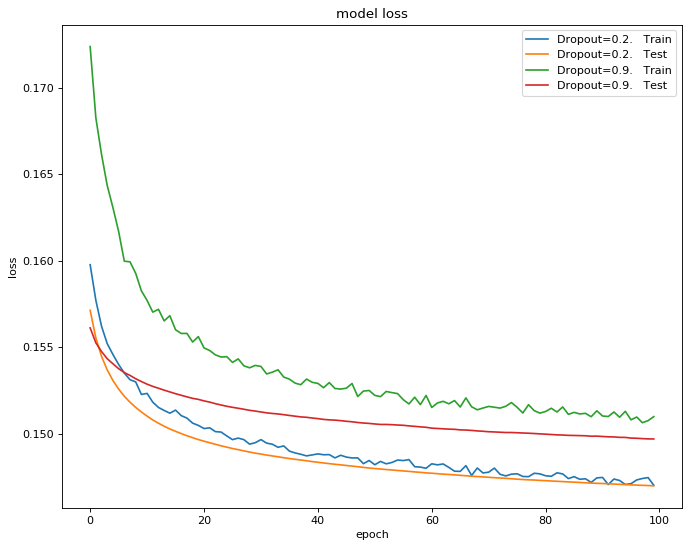

In [122]:
figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history.history['loss'],label="Dropout=0.2.   Train")
plt.plot(history.history['val_loss'],label="Dropout=0.2.   Test")

plt.plot(history09.history['loss'],label="Dropout=0.9.   Train")
plt.plot(history09.history['val_loss'],label="Dropout=0.9.   Test")


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

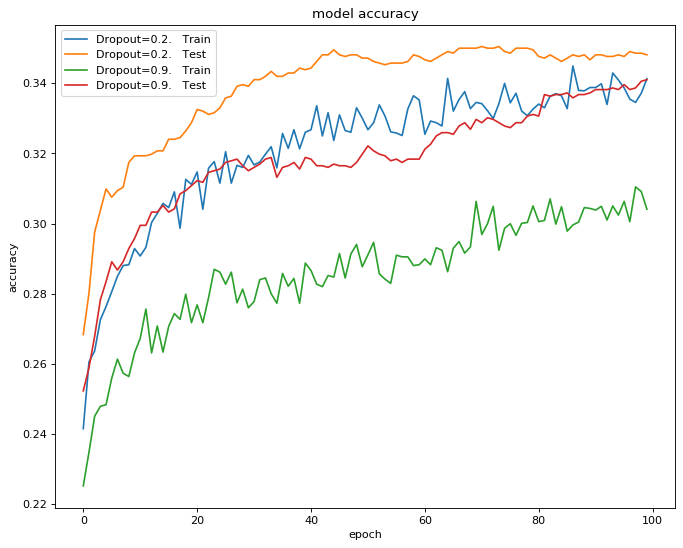

In [123]:
figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history.history['accuracy'],label="Dropout=0.2.   Train")
plt.plot(history.history['val_accuracy'],label="Dropout=0.2.   Test")

plt.plot(history09.history['accuracy'],label="Dropout=0.9.   Train")
plt.plot(history09.history['val_accuracy'],label="Dropout=0.9.   Test")


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

La eficiencia del modelo bajó para un dropout alto. Al tener la mayoría de neuronas apagadas el modelo pierde capacidad de aprender. También se ve mayor diferencia entre valores de train y test.

En este trabajo pudimos ver como infiere en el resultado los diferentes valores de batch size y dropout. También analizamos diferencias al agregar diferentes columnas, cambiar la arquitectura de la red neuronal utilizada y utilizar diferentes funciones de activación.

Además pudimos observar la variación de las métricas loss y accuracy en función del número de epoch.

En el modelo que mejores resultados arrojó, se obtuvo:

test loss: 1.33 - accuracy: 0.37